# Loading Data 

Pertama, kita bikin list of word vectornya dulu sebagai bentuk word embedding.
Ini kita pake yang yg udh di train dari Glove, jadi basically ngk usah train word embedding lagi.
Isinya 400 ribu kata, dengan dimensi vektor 50.
Cmn kayanya perlu dihandle lagi word embeddingnya, karena feeling gua OOV-nya bakal banyak.
Opsinya : 1. Train lagi word embeddingnya pake dataset 2. Normalisasi input 3. Handle OOV pake word similarity, cari yang paling deket tapi komputasinya gede karena bandingin sama 400k kata
Sementara, biar simple kalo OOV langsung diset vektor UNKNOWN (yang ke-39999)

In [1]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


Kita itung dulu rata-rata jumlah kata per tweet, buat nentuin maximum sequence length, biar sama semua dimensi embeddingnya per input tweet

In [2]:
import pandas as pd

df = pd.read_csv("tweets.csv")

numWords = []
for i in range(0, len(df)):
    row = df.iloc[i]
    numWords.append(len(row['opinion'].split()))

print('The total number of opinion is', len(df))
print('The total number of words is', sum(numWords))
print('The average number of words is', sum(numWords)/len(numWords))

The total number of opinion is 110
The total number of words is 1541
The average number of words is 14.00909090909091


Visualisasi histogram jumlah kata per tweet buat di laporan

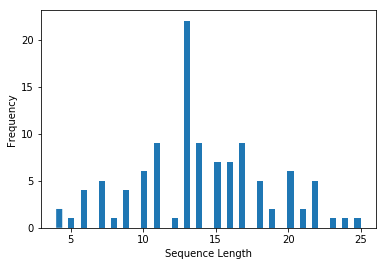

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

Set dimensi word embedding 50 sesuai Glove, set maxSeqLength 20 ambil sedikit di atas rata-rata (14)

In [4]:
# Dimensions for each word vector
# numDimensions = 300
# Harusnya 50, ngk ngerti kenapa dia bikin 300
numDimensions = 50
maxSeqLength = 20

Preprocessing : 1. Lowercase 2. Buang tanda baca dan karakter2 ngk penting

In [5]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

Ubah dataset jadi matrix vector

In [13]:
ids = np.zeros((len(df), maxSeqLength+1), dtype='int32')
fileCounter = 0

for i in range(0, len(df)):
    print(i)
    indexCounter= 0
    row = df.iloc[i]
    line = row['opinion']
    sentiment = row['sentiment']
    if (str(sentiment) == 'positif'):
        ids[fileCounter][maxSeqLength] = -1 #kelas positif
    else:
        ids[fileCounter][maxSeqLength] = -2 #kelas negatif
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        if('http' not in word):
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
    fileCounter = fileCounter + 1 
        
#Pass into embedding function and see if it evaluates. 

np.save('idsMatrixBallon', ids)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


In [14]:
ids = np.load('idsMatrixBallon.npy')
ids[0:5]

array([[    47, 399999,     79,    111,  18471,      5,     32,   4943,
           378,    236,     68,     10,   7035,     79,   8160,      0,
             0,      0,      0,      0,     -1],
       [    47, 399999,     79,    111,      5, 399999,     32,   4943,
           378,    236,     68,     10,   7035,     79,  19087,      0,
             0,      0,      0,      0,     -1],
       [ 20956,  46501,   1733,  19087, 103285,  19087, 399999, 399999,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,     -1],
       [  1716,    182,     62,     61, 201534,    493,    398,     10,
          8160,      4,    320, 399999,   2715,    197,   9956,     18,
            14,   8457,    197,    181,     -2],
       [399999,     81,    269,   8160,     14,   6034,    113,      3,
        399999,   1284,     46,    120,  12594,     17,   2145,    236,
           186,      0,      0,      0,     -1]])

# Helper Functions

Below you can find a couple of helper functions that will be useful when training the network in a later step. 

In [21]:
from random import randint
batchSize = 10

def getTrainBatch(start):
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        idx = i + batchSize*start
        if(ids[idx][maxSeqLength] == -1):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[idx][0:maxSeqLength]
    return arr, labels

def getTestBatch(start):
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        idx = i + batchSize*start
        if(ids[idx][maxSeqLength] == -1):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[idx][0:maxSeqLength]
    return arr, labels

# arr, labels = getTrainBatch(0)
# arr[0:10]

# RNN Model

Hyperparam dari RNN

In [22]:
batchSize = 10
lstmUnits = 64
numClasses = 2
iterations = 100000

Placeholder buat label (positif/negatif) sama input kalimat

In [23]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
print(labels)
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])
input_data

Tensor("Placeholder:0", shape=(10, 2), dtype=float32)


<tf.Tensor 'Placeholder_1:0' shape=(10, 20) dtype=int32>

In [24]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors, input_data)
data

<tf.Tensor 'embedding_lookup:0' shape=(10, 20, 50) dtype=float32>

Set jumlah lstm sama dropout. Masukin format data ke lstm.

In [25]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

Inisialisasi2 Awal

In [26]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

Variabel evaluasi

In [27]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

Optimizer : Adam, Output function : softmax

In [28]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Loss dan accuracy visualization

In [31]:
import datetime
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

(20, 50)


# Hyperparameter Tuning

Choosing the right values for your hyperparameters is a crucial part of training deep neural networks effectively. You'll find that your training loss curves can vary with your choice of optimizer (Adam, Adadelta, SGD, etc), learning rate, and network architecture. With RNNs and LSTMs in particular, some other important factors include the number of LSTM units and the size of the word vectors.

* Learning Rate: RNNs are infamous for being diffult to train because of the large number of time steps they have. Learning rate becomes extremely important since we don't want our weight values to fluctuate wildly as a result of a large learning rate, nor do we want a slow training process due to a low learning rate. The default value of 0.001 is a good place to start. You should increase this value if the training loss is changing very slowly, and decrease if the loss is unstable.  
* Optimizer: There isn't a consensus choice among researchers, but Adam has been widely popular due to having the adaptive learning rate property (Keep in mind that optimal learning rates can differ with the choice of optimizer).
* Number of LSTM units: This value is largely dependent on the average length of your input texts. While a greater number of units provides more expressibility for the model and allows the model to store more information for longer texts, the network will take longer to train and will be computationally expensive. 
* Word Vector Size: Dimensions for word vectors generally range from 50 to 300. A larger size means that the vector is able to encapsulate more information about the word, but you should also expect a more computationally expensive model. 

# Training

The basic idea of the training loop is that we first define a Tensorflow session. Then, we load in a batch of reviews and their associated labels. Next, we call the session’s `run` function. This function has two arguments. The first is called the "fetches" argument. It defines the value we’re interested in computing. We want our optimizer to be computed since that is the component that minimizes our loss function. The second argument is where we input our `feed_dict`. This data structure is where we provide inputs to all of our placeholders. We need to feed our batch of reviews and our batch of labels. This loop is then repeated for a set number of training iterations.

Instead of training the network in this notebook (which will take at least a couple of hours), we’ll load in a pretrained model.

If you decide to train this notebook on your own machine, note that you can track its progress using [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard). While the following cell is running, use your terminal to enter the directory that contains this notebook, enter `tensorboard --logdir=tensorboard`, and visit http://localhost:6006/ with a browser to keep an eye on your training progress.

In [34]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

iterations = 1100
start = 0
for i in range(iterations):
    print(i)
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch(start);
    if(start < (len(df)/batchSize)-1):
        start = start + 1
    else:
        start = 0
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
#     if (i % 10000 == 0 and i != 0):
#         save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
#         print("saved to %s" % save_path)
writer.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Loading a Pretrained Model

Our pretrained model’s accuracy and loss curves during training can be found below. 

![caption](Images/SentimentAnalysis6.png)
![caption](Images/SentimentAnalysis7.png)

Looking at the training curves above, it seems that the model's training is going well. The loss is decreasing steadily, and the accuracy is approaching 100 percent. However, when analyzing training curves, we should also pay special attention to the possibility of our model overfitting the training dataset. Overfitting is a common phenomenon in machine learning where a model becomes so fit to the training data that it loses the ability to generalize to the test set. This means that training a network until you achieve 0 training loss might not be the best way to get an accurate model that performs well on data it has never seen before. Early stopping is an intuitive technique commonly used with LSTM networks to combat this issue. The basic idea is that we train the model on our training set, while also measuring its performance on the test set every now and again. Once the test error stops its steady decrease and begins to increase instead, you'll know to stop training, since this is a sign that the network has begun to overfit. 

Loading a pretrained model involves defining another Tensorflow session, creating a Saver object, and then using that object to call the restore function. This function takes into 2 arguments, one for the current session, and one for the name of the saved model. 

In [ ]:
# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
# saver.restore(sess, tf.train.latest_checkpoint('models'))

Then we’ll load some movie reviews from our test set. Remember, these are reviews that the model has not been trained on and has never seen before. The accuracy for each test batch can be seen when you run the following code. 

In [36]:
iterations = 11
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch(i);
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0
Accuracy for this batch: 100.0


In [44]:
def getSentenceMatrix(sentence):
    sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter, word in enumerate(split):
        if(indexCounter >= maxSeqLength):
            break
        try:
            sentenceMatrix[0,indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix

inputText = input()
inputMatrix = getSentenceMatrix(inputText)

predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]
# predictedSentiment[0] represents output score for positive sentiment
# predictedSentiment[1] represents output score for negative sentiment

if (predictedSentiment[0] > predictedSentiment[1]):
    print("Positive Sentiment")
else:
    print("Negative Sentiment")

Ronaldo is very good
Negative Sentiment


# Conclusion

In this notebook, we went over a deep learning approach to sentiment analysis. We looked at the different components involved in the whole pipeline and then looked at the process of writing Tensorflow code to implement the model in practice. Finally, we trained and tested the model so that it is able to classify movie reviews.

With the help of Tensorflow, you can create your own sentiment classifiers to understand the large amounts of natural language in the world, and use the results to form actionable insights. Thanks for reading and following along!